In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shutil
import os
import time
from collections import defaultdict
from PIL import Image
from matplotlib.pyplot import imsave

import facenet
import lfw
import foolbox

import mp

## 1. create a general mean-filter Tensorflow graph

In [3]:
def make_mean_filter_graph(filter_size=3):
    """Creates a graph that computes a (filter_size x filter_size) mean filter.
    
    The graph performs:
        'input' -> avg_pool (same as a mean filter) -> 'output'
    
    'input' shape should be (batch_size, height, width, num_channels)
    'output' shape is same as input shape
    
    returns:
        (input_placeholder, output_placeholder, graph_object)
    """
    with tf.Graph().as_default() as graph:
        face_input_img = tf.placeholder(tf.float32, name="input")
        y = tf.nn.avg_pool(face_input_img, [1, filter_size, filter_size, 1], [1, 1, 1, 1], 'SAME')
        # NOTE: using identity to get a known name for the output tensor.
        output = tf.identity(y, name="output")
    return (face_input_img, output, graph)

In [4]:
size = 100
faces1, faces2, labels = mp.load_testset(size)

In [5]:
def mean_filter_faces(filter_size):
    """Applied a mean filter to all images in faces1"""
    face_input_img, output, graph = make_mean_filter_graph(filter_size)
    with tf.Session(graph=graph) as sess:
        return sess.run(output, feed_dict={face_input_img: faces1})

In [6]:
filter_size = 3

In [7]:
face_input_img, output, graph = make_mean_filter_graph(filter_size)

In [8]:
gdef = graph.as_graph_def()

In [9]:
[n.name for n in gdef.node]

['input', 'AvgPool', 'output']

In [10]:
def make_filter_plotter(filter_size):
    filtered_faces = mean_filter_faces(filter_size)
    
    def plot_mean_filter(img_index):
        orig_img = faces1[img_index]
        new_img = filtered_faces[img_index]
        plt.subplot(1, 2, 1)
        plt.title('Original')
        plt.imshow(orig_img)
        plt.subplot(1, 2, 2)
        plt.title('With {f}x{f} mean filter'.format(f=filter_size))
        plt.imshow(new_img)
        print('change in norm:', np.linalg.norm(orig_img - new_img))
        
    return plot_mean_filter

In [11]:
plot_3x3_filter = make_filter_plotter(3)

change in norm: 1.6893917187721397


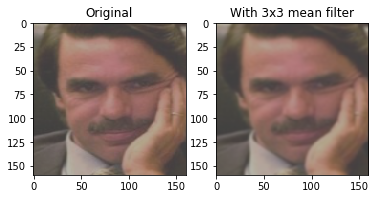

In [12]:
plot_3x3_filter(0)

In [13]:
plot_12x12_filter = make_filter_plotter(12)

change in norm: 8.742888951421827


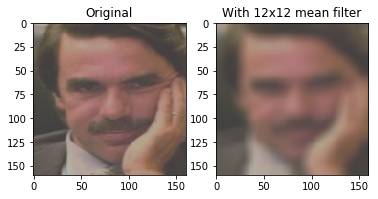

In [14]:
plot_12x12_filter(0)

## 2. 'Prepend' a mean filter to our facenet model

Here we modify `InceptionResnetV1Model.__init__` to take a parameter `mean_filter_size` that determines the size of the mean filter to apply to all images that it operates on. We change the Tensorflow graph to first apply a mean filter (as per `make_mean_filter_graph` above) on the input image, and then pass the blurred image through the original pre-trained inception resnet model.

Note that we are using a pre-trained model, so the mean filter is purely operating at inferance-time, not during training. This is technically causes a mismatch between train/test data distributions, but will still illustrate whether an attack is as effective on the mean-filtered image as on an original image.

In [15]:
class InceptionResnetV1Model():
  model_path = "../models/20180402-114759/20180402-114759.pb"

  def __init__(self, mean_filter_size=0):
    """
    mean_filter_size -- size of a mean filter to be applied on every input image
    """
    # Load Facenet CNN
    facenet.load_model(self.model_path)
    # Save input and output tensors references
    graph = tf.get_default_graph()
    self.face_input = graph.get_tensor_by_name("input:0")
    self.embedding_output = graph.get_tensor_by_name("embeddings:0")
    
    self.graph = graph
    
    # prepend the mean filter if used
    if mean_filter_size > 0:
        mean_filter_input, mean_filter_output, mean_filter_graph = \
            make_mean_filter_graph(mean_filter_size)
        
        g1_def = mean_filter_graph.as_graph_def()
        g2_def = graph.as_graph_def()
    
        # https://stackoverflow.com/questions/33748552/tensorflow-how-to-replace-a-node-in-a-calculation-graph/33770771
        with tf.Graph().as_default() as g_combined:
            self.face_input = tf.placeholder(tf.float32, name="input")
            mean_filtered_faces, = tf.import_graph_def(
                g1_def,
                input_map={"input:0": self.face_input}, return_elements=["output:0"]
            )
            self.embedding_output, = tf.import_graph_def(
                g2_def,
                input_map={"input:0": mean_filtered_faces, 'phase_train:0': False}, return_elements=["embeddings:0"]
            )

        # override the model's graph with our new combined graph
        self.graph = g_combined

  def convert_to_classifier(self):
    with self.graph.as_default():
        # Create victim_embedding placeholder
        self.victim_embedding_input = tf.placeholder(
            tf.float32,
            shape=(None, 512))

        # Squared Euclidean Distance between embeddings
        self.distance = tf.reduce_sum(
            tf.square(self.embedding_output - self.victim_embedding_input),
            axis=1)

        # Convert distance to a softmax vector
        # 0.99 out of 4 is the distance threshold for the Facenet CNN
        threshold = 0.99
        score = tf.where(
            self.distance > threshold,
            0.5 + ((self.distance - threshold) * 0.5) / (4.0 - threshold),
            0.5 * self.distance / threshold)
        reverse_score = 1.0 - score
        self.softmax_output = tf.transpose(tf.stack([reverse_score, score]))

        # Save softmax layer
        self.layer_names = []
        self.layers = []
        self.layers.append(self.softmax_output)
        self.layer_names.append('logits')

  def convert_to_targeted_classifier(self, victim):
    with self.graph.as_default():
        # Create victim_embedding placeholder
        self.victim_embedding_input = tf.constant(
            victim,
            shape=(1, 512))

        # Squared Euclidean Distance between embeddings
        self.distance = tf.reduce_sum(
            tf.square(self.embedding_output - self.victim_embedding_input),
            axis=1)

        # Convert distance to a softmax vector
        # 0.99 out of 4 is the distance threshold for the Facenet CNN
        threshold = 0.99
        score = tf.where(
            self.distance > threshold,
            0.5 + ((self.distance - threshold) * 0.5) / (4.0 - threshold),
            0.5 * self.distance / threshold)
        reverse_score = 1.0 - score

        self.softmax_output = tf.transpose(tf.stack([reverse_score, score]))

        # Foolbox expects logits
        self.logits = tf.log(self.softmax_output)

        # Save softmax layer
        self.layer_names = []
        self.layers = []
        self.layers.append(self.logits)
        self.layer_names.append('logits')

  def fprop(self, x, set_ref=False):
    return dict(zip(self.layer_names, self.layers))

## 3. An example attack on our mean-filtering facenet model

Here we demonstrate an exmaple FGSM attack on our mean-filtering face identification model.

In [16]:
filter_size = 3

In [17]:
tf.Graph().as_default()
# Load model
model = InceptionResnetV1Model(filter_size)
# Convert to classifier
with model.graph.as_default():
    model.convert_to_classifier()

    # Load pairs of faces and their labels in one-hot encoding
    faces1, faces2, labels = mp.load_testset(size)
    binary_labels = [0 if labels[i][0] == 1 else 1 for i in range(size)]

    # Create victims' embeddings using Facenet itself
    graph = tf.get_default_graph()

    with tf.Session() as sess:
        feed_dict = {model.face_input: faces2}
        victims_embeddings = sess.run(model.embedding_output, feed_dict=feed_dict)
        feed_dict = {model.face_input: faces1}
        non_victims_embeddings = sess.run(model.embedding_output, feed_dict=feed_dict)

Model filename: ../models/20180402-114759/20180402-114759.pb
Instructions for updating:
Use tf.gfile.GFile.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
i = 0
with tf.Session(graph=model.graph) as sess:
    model.convert_to_targeted_classifier(victims_embeddings[i])
    model_fb = foolbox.models.TensorFlowModel(model.face_input, model.logits, (0, 1), {})

    attack = foolbox.v1.attacks.FGSM(model_fb)
    adversarial = attack(faces1[i:i+1][0], label=0)

In [19]:
plot_filtered_img = make_filter_plotter(filter_size)

change in norm: 1.6893917187721397


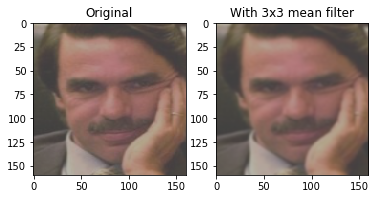

In [20]:
plot_filtered_img(i)
# on the right is the mean-filtered image that is passed to the inception resnet model.

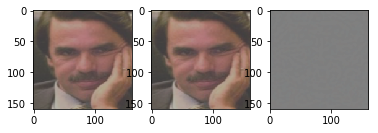

In [21]:
plt.subplot(1, 3, 1)
plt.imshow(faces1[i])

plt.subplot(1, 3, 2)
plt.imshow(adversarial)

plt.subplot(1, 3, 3)
plt.imshow(adversarial - faces1[i] + 0.5)

In [22]:
np.linalg.norm(adversarial - faces1[i])

0.6978432955506038

## 4. Run each of the attacks on the mean-filtering model

In [23]:
attacks = {
    'fgsm': foolbox.v1.attacks.FGSM,
    'deep_fool': foolbox.v1.attacks.DeepFoolL2Attack,
    'guassian_noise': foolbox.v1.attacks.AdditiveGaussianNoiseAttack,
    'uniform_noise': foolbox.v1.attacks.AdditiveUniformNoiseAttack,  
}

In [24]:
filter_size = 3

In [25]:
# model = InceptionResnetV1Model(filter_size)
# model.convert_to_classifier()
# sess = tf.Session(graph=model.graph)
# graph = model.graph
# tf.reset_default_graph()

In [26]:
progress_fn = 'mean_filter_experiment_progress.txt'
def run_attack(i, attack_name):
    """run a given attack for the image with index `i`"""
    tf.reset_default_graph()
    
    model = InceptionResnetV1Model(filter_size)
    model.convert_to_classifier()

    with tf.Session(graph=model.graph) as sess:
        attack_constructor = attacks[attack_name]

        with open(progress_fn, 'a') as f:
            f.write("Starting attack {} on image {}\n".format(attack_name, i))

        t0 = time.time()
        model.convert_to_targeted_classifier(victims_embeddings[i])
        model_fb = foolbox.models.TensorFlowModel(model.face_input, model.logits, (0, 1), {})
        t1 = time.time()

        attack = attack_constructor(model_fb)
        adversarial = attack(faces1[i:i+1][0], label=binary_labels[i])
        t2 = time.time()

        if adversarial is not None:
            diff = np.linalg.norm(adversarial - faces1[i])
            model.convert_to_classifier()
            feed_dict = {model.face_input: [adversarial]}
            adversarial_embedding = sess.run(model.embedding_output, feed_dict=feed_dict)[0]
        else:
            diff = None
            adversarial_embedding = None
        t3 = time.time()

        with open(progress_fn, 'a') as f:
            f.write('durations: {} {} {}\n'.format(t1 - t0, t2-t1, t3-t2))
        return {
            'changed': diff,
            'adversarial': adversarial,
            'adversarial_embedding': adversarial_embedding,
        }

In [23]:
experiment_size = 50

def generate_data():
    os.remove(progress_fn)
    attack_to_data = defaultdict(list)
    for attack_name in attacks:
        changed = []
        adversarials = []

        for i in range(experiment_size):
            res = run_attack(i, attack_name)
            changed.append(res['changed'])
            adversarials.append(res['adversarial'])

        attack_to_data[attack_name] = {
            'changed': changed,
            'adversarials': adversarials
        }
    return attack_to_data

In [24]:
## utility code for checking memory usage
import os
import psutil
process = psutil.Process(os.getpid())
print(process.memory_info().rss / 1e9)
# 1st experiment run: 2.540982272 GB
# 2nd experiment run: 2.442838016 GB -> nice! no memory leak, it appears

1.890271232


In [6]:
filename = 'attack_results/mean_attack_to_data_copy.pkl'

# load results
with open(filename, 'rb') as f:
    attack_to_data = pickle.load(f)

# save results
# large_attack_to_data = generate_data()
# with open(filename, 'wb') as f:
#     pickle.dump(large_attack_to_data, f)

## 5. We now compare these new results to the previous results

To evaluate the efficacy of the attacks without and with our blurring defense, we observe:

1. (general evaluation of blurring as part the face recognition system) the effect of the blurring defense on the original images. how much did the norm change? is the original classifier still effective?
2. rate of attacker failure
3. the change in norm between the attacker's adversarial image and the original image. We believe that in the defended network, the norm will much greater because the mean filter roughly makes the attacker more "lossy", meaning that attacker needs to make larger perturbations to change the img's classification.
4. change in the norm of the distance between the adversarial embedding and the original embedding

### 5.1

In [ ]:
for i in range(50): 
    blurred = cv2.blur(faces1[i], (3,3))
    feed_dict = {model.face_input: np.array([faces1[i]]),
                 model.victim_embedding_input: victims_embeddings[i:i+1],
                 phase_train_placeholder: False,
                 batch_size: 1}
    prediction = sess.run(model.softmax_output, feed_dict=feed_dict).argmax(axis=-1)[0]
    if (prediction != binary_labels[i]):
         print("Misclassification for example ", i)

Same results as base FaceNet, one image misclassified. So this is a reasonable defense and should not effect honest participants

### 5.2 and 5.3

In [2]:
with open('full_results', 'rb') as f:
    old_results = pickle.load(f)

In [3]:
def analyze_results_for_attack(res, attack_name):
    already_misclassified = []
    attack_failures = []
    norm_changed = []
    chg = res[attack_name]['changed']
    
    N = len(chg)
    for i in range(N):
        if chg[i] is None:
            attack_failures.append(i)
        elif chg[i] == 0:
            already_misclassified.append(i)
        else:
            norm_changed.append(chg[i])
    
    print('=== {} ==='.format(attack_name))
    print('# already misclassified:', len(already_misclassified))
    print('# failures:', len(attack_failures))
    
    plt.title('norm change distribution for {}'.format(attack_name))
    plt.plot(sorted(norm_changed))
    avg = np.average(norm_changed)
    plt.axhline(y=avg, xmin=0, xmax=len(norm_changed), label='avg {:0.2f}'.format(avg), linestyle='--')
    plt.legend()
    plt.show()
    
def analyze_results(results):
    for attack_name in results.keys():
        analyze_results_for_attack(results, attack_name)

=== fgsm ===
# already misclassified: 1
# failures: 5


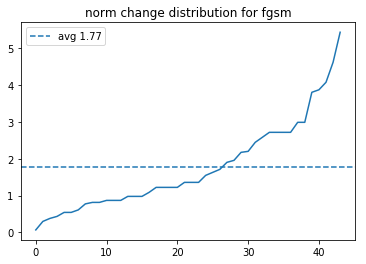

=== deep_fool ===
# already misclassified: 1
# failures: 0


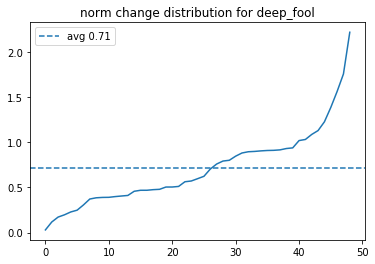

=== guassian_noise ===
# already misclassified: 1
# failures: 23


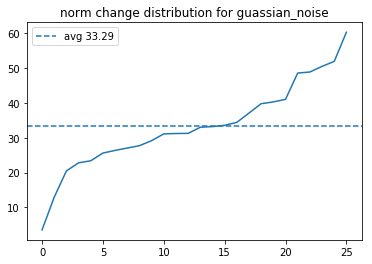

=== uniform_noise ===
# already misclassified: 1
# failures: 24


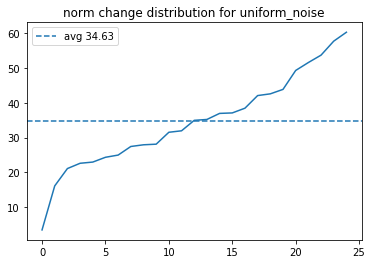

In [4]:
analyze_results(old_results)

In [36]:
attack_to_data

defaultdict(list,
            {'fgsm': {'changed': [0.6978432955506038,
               0.0,
               1.559884983599058,
               4.378624649507606,
               1.0399233223993747,
               3.1197699671981156,
               4.104960322185217,
               1.2314880711686185,
               3.1197699671981156,
               2.736640214790149,
               1.9156482523008918,
               None,
               None,
               2.8597890728809072,
               2.0798466447987494,
               None,
               0.6567936974261435,
               1.7240833760969083,
               3.379750861515339,
               1.5598849835990578,
               1.0946561623769013,
               None,
               1.6419841798479817,
               0.5199616611996872,
               2.8597890728809072,
               3.2839683596959643,
               None,
               2.599808178563684,
               5.19961635712737,
               0.8209920899239911,
      

=== fgsm ===
# already misclassified: 1
# failures: 5


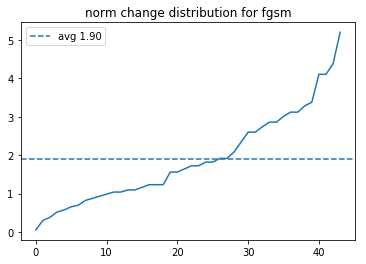

=== deep_fool ===
# already misclassified: 1
# failures: 0


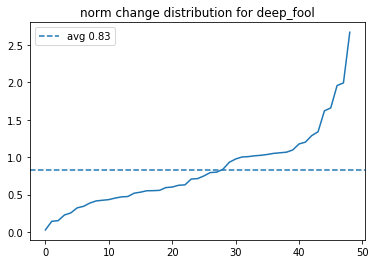

=== guassian_noise ===
# already misclassified: 1
# failures: 23


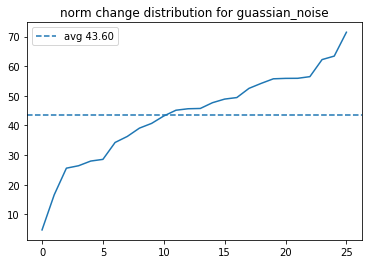

In [7]:
analyze_results(attack_to_data)

In [34]:
def pretty_attack_name(attack_name):
    if (attack_name == 'fgsm'):
        return 'FGSM'
    elif (attack_name == 'deep_fool'):
        return 'DeepFool'
    elif (attack_name == 'uniform_noise'):
        return 'Additive Uniform Noise'
    else:
        return 'Additive Gaussian Noise'

def compare_results_for_attack(res_orig, res_new, attack_name):
    print('=== {} ==='.format(attack_name))    

    norm_changed_orig = []
    norm_changed_new = []
    chg_orig = res_orig[attack_name]['changed']
    chg_new = res_new[attack_name]['changed']
    assert len(chg_orig) == len(chg_new)
    
    N = len(chg_orig)
    for i in range(N):
        if chg_orig[i]:
            if chg_new[i] is None or chg_new[i] == 0:
                print('index {} now fails to be attacked'.format(i))
            else:
                norm_changed_orig.append(chg_orig[i])
                norm_changed_new.append(chg_new[i])
    
    plt.title(r'Distribution of $||\Delta||$ for {} Attack'.format(pretty_attack_name(attack_name)))
    plt.plot(sorted(norm_changed_orig), color='b', label=r'$||\Delta||$, pre-defense')
    plt.plot(sorted(norm_changed_new), color='g', label=r'$||\Delta||$, post-defense')
    
    num_changed = len(norm_changed_orig)
    avg_orig = np.average(norm_changed_orig)
    plt.axhline(y=avg_orig, xmin=0, xmax=num_changed, label=r'Average $||\Delta||$, pre-defense = {:0.2f}'.format(avg_orig), linestyle='--', color='b')
    avg_new = np.average(norm_changed_new)
    plt.axhline(y=avg_new, xmin=0, xmax=num_changed, label=r'Average $||\Delta||$, post-defense = {:0.2f}'.format(avg_new), linestyle='--', color='g')
    plt.xlabel('Test pair #')
    plt.ylabel(r'$||\Delta||$')
    plt.legend()
    plt.savefig(attack_name + '-defense.png', dpi=600)
    plt.show()

    
def compare_results(results_orig, results_new):
    for attack_name in (results_orig.keys() & results_new.keys()):
        compare_results_for_attack(results_orig, results_new, attack_name)

=== deep_fool ===


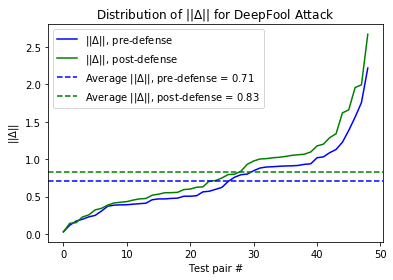

=== fgsm ===


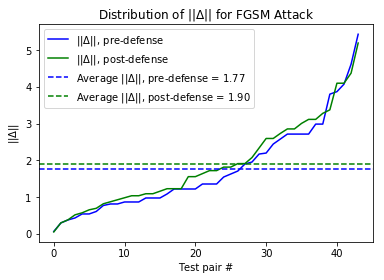

=== guassian_noise ===
index 34 now fails to be attacked


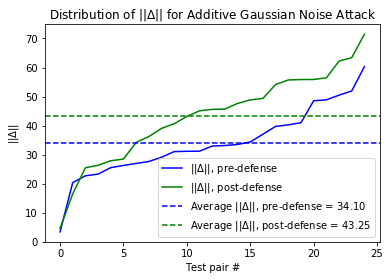

In [35]:
compare_results(old_results, attack_to_data)

The change in norm required for the attack to succeed increases for each of the attacks, when the defense is applied. Understandably, the change is less dramatic in deep_fool and fgsm as in the noise attack. Also, because gaussian noise and uniform noise are nearly identical in effect in results, I decided to start omitting uniform noise from the analysis (unless you think otherwise, in which case I could easily get the results, I think it would make sense for us to just omit random noise altogether)

Note that the rate of failure is identical, except for gaussian noise which makes one more failure in the defended network (totaling to 24/50 instead of 23/50